In [ ]:
import pandas as pd

data = pd.read_csv("/content/NetflixStock.csv")  # 데이터 파일을 읽어옴
data.head()  # 5개의 데이터를 표시

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [ ]:
data.info() #결측치 여부 등 파악

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


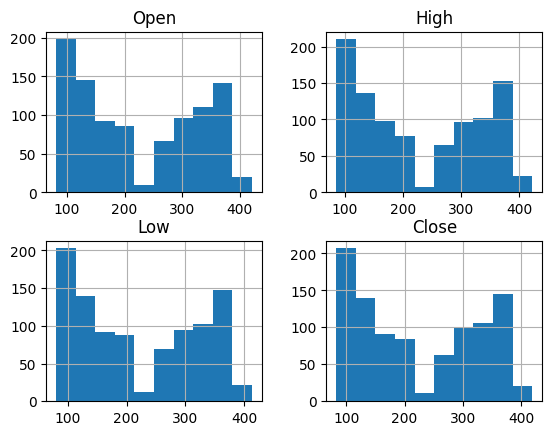

In [ ]:
#데이터 분포 확인하기
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4]  # 개장가, 최고가, 최저가 추가
data_used["Close"] = data["Close"]  # 종가 추가
hist = data_used.hist()
plt.show()

In [ ]:
#pytorch용 데이터셋 클래스 정의

import numpy as np
from torch.utils.data.dataset import Dataset


#Netflix 데이터셋 클래스 구현

class Netflix(Dataset):  #클래스 선언
    def __init__(self):
        self.csv = pd.read_csv("/content/NetflixStock.csv")        #데이터 읽기

        # 입력 데이터 정규화 (0~1 사이로 스케일링)
        self.data = self.csv.iloc[:, 1:4].values   #종가(close)를 제외한 데이터(open, high, low)
        self.data = self.data / np.max(self.data)  #정규화 #(todo) 0과 1 사이의 값을 갖도록 정규화하세요

        #종가 데이터 정규화
        self.label = data["Close"].values #예측할 값은 종가(close)
        self.label = self.label / np.max(self.label)

    #데이터셋 크기 반환 함수.
    #학습 데이터가 30일씩 슬라이싱되므로, 전체 길이에서 30을 뺀만큼만 유효한 샘플로 사용함
    def __len__(self):
        return len(self.data) - 30 #사용 가능한 배치 개수

    #특정 index에 해당하는 샘플 반환하기
    def __getitem__(self, i):
        data = self.data[i:i+30] # 과거 30일치 시계열 데이터 (입력값) :: 즉, 30일씩 슬라이싱하여 입력값으로 사용할 것이다.
        label = self.label[i+30] # 그 다음 날 종가 (예측값) #! 그 다음 30일동안의 종가가 아님!!, 단일 시점을 예측하는 것임.

        return data, label


In [ ]:
#RNN 클래스 정의
import torch
import torch.nn as nn


#RNN모델 정의
class RNN(nn.Module):

   #모델에서 사용할 레이어 층들을 정의
   def __init__(self):
       super(RNN, self).__init__()


       self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5,
                         batch_first=True)  #RNN층의 정의
      #(생각해보기) 왜 input_size가 3일까요?
        #답: input_size는 하나의 시점에서 입력되는 feature의 개수를 의미함. 개장가, 최고가, 최저가 총 3개의 열을 사용함.
        #    즉, 1일에 대한 feature의 수가 3이기 때문에 input_size = 3임.
      #(알아보기) batch_first는 무슨 역할을 할까?
        #답: RNN의 입력 텐서 모양을 (batch, seq_len, input_size)로 수정해줌.
        # 직관적으로 다루기 쉽기 때문


       #주가를 예측하는 MLP층 정의
       #(생각해보기) 왜 in_features가 240이어야할까?
          # 시계열 길이가 30일이고, hidden_size를 8로 설정했기 때문에 30 * 8 = 240임

       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64, out_features=1)
      #(생각해보기) 왜  out_features가 1인가?
        # 예측해야하는 값은 하루 뒤의 종가임. 즉, 1개의 값을 예측하기 때문임

       self.relu = nn.ReLU() # 활성화 함수 정의



  #모델이 실제 입력값을 받아 예측을 수행하는 부
   def forward(self, x, h0):
       x, hn = self.rnn(x, h0)  #RNN층의 출력 #RNN의 출력값은 (batch, 30(days), 8(hidden states) 모양임

       #MLP층의 입력으로 사용될 수 있도록 모양 변경 -> (batch, 240)으로 펼침
       x = torch.reshape(x, (x.shape[0], -1))

       # MLP 층을 이용해 종가를 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

In [ ]:
#모델, 데이터셋 정의
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)  # 모델의 정의
dataset = Netflix()  # Netflix 데이터를 로딩하고 전처리한 데이터셋 사용

In [ ]:
loader = DataLoader(dataset, batch_size=32)  # 배치 단위로 데이터를 불러올 수 있도록 설정

In [ ]:
optim = Adam(params=model.parameters(), lr=0.0001) # Adam 최적화 알고리즘 사용

In [ ]:
for epoch in range(200):
   iterator = tqdm.tqdm(loader)#프로그레바 표시
   for data, label in iterator:
       optim.zero_grad()# 기존 gradient 초기화

       # 초기 은닉 상태 정의
       h0 = torch.zeros(5, data.shape[0], 8).to(device)

       # 모델 예측
       pred = model(data.type(torch.FloatTensor).to(device), h0)

       # 평균제곱오차 손실 계산
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))
       loss.backward()  # 오차 역전파
       optim.step()  # 최적화 진행(파라미터 업데이)

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")# 진행률 표시

torch.save(model.state_dict(), "./rnn.pth")  # 학습한 모델 가중치를 파일로 저장

epoch199 loss:0.00035782501799985766: 100%|██████████| 30/30 [00:00<00:00, 185.82it/s]


In [ ]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1) # 한 개씩 불러와 예측

preds = [] # 예측 결과 저장
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  #초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())  #예측값을 리스트에 추가
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))  # 손실계산
       total_loss += loss/len(loader)  # 전체 손실 평균

total_loss.item()

0.0013573995092883706

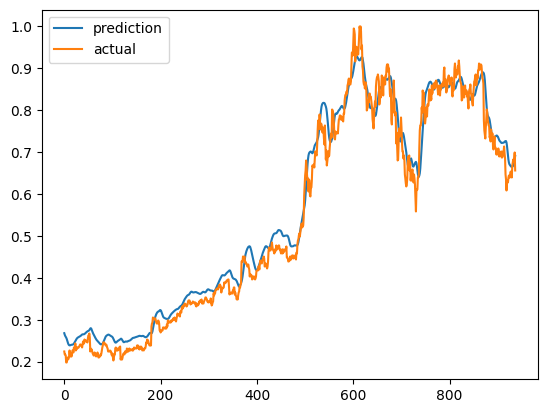

In [ ]:
plt.plot(preds, label="prediction")# 예측값 선 그래프
plt.plot(dataset.label[30:], label="actual")# 실제 종가 (30일 이후부터 비교하기 위해서)
plt.legend()
plt.show()


#(생각해보기)x축이 왜 800칸이 넘게 나올까?
  # 한 샘플당 30일치를 입력으로 사용하고, 그 다음날의 종가 1개를 예측하므로, 예측 가능한 시점이 전체샘플 수에서 30을 뺀 값이다.
  # 그러므로 800칸 이상의 예측값이 나올 수 있다.